In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
pd.options.plotting.backend = "plotly"

In [38]:
df = pd.read_csv('datasets/users.db.csv')
categorical_columns = ['voyage', 'laugh', 'photo_keke', 'photo_beach', 'gender']

df.drop(columns=['last.pr.update'], inplace=True)
df[['last.up.photo', 'last.connex', 'date.crea']] = df[['last.up.photo', 'last.connex', 'date.crea']].apply(pd.to_datetime)
df['account_age'] = (df['last.connex'] - df['date.crea']).dt.days
df.drop(df[df['account_age'] < 0].index, inplace = True)
df.columns = df.columns.str.replace('.', '_')
df['gender'].replace({2 : np.nan}, inplace=True)
#df[categorical_columns] = df[categorical_columns].apply(lambda x: np.where(x < 0, np.nan))
df.dropna(inplace = True)
df.head()

/var/folders/lg/3cfjf86d1ll_sbdjpdpm8p840000gn/T/ipykernel_23425/1633119170.py:8: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



,userid,date_crea,score,n_matches,n_updates_photo,n_photos,last_connex,last_up_photo,gender,sent_ana,length_prof,voyage,laugh,photo_keke,photo_beach,account_age
0,1,2011-09-17,1.495834,11,5,6,2011-10-07,2011-10-02,1.0,6.490446,0.000000,0,0,0,0,20
1,2,2017-01-17,8.946863,56,2,6,2017-01-31,2017-02-03,1.0,4.589125,20.722862,0,0,0,1,14
2,3,2019-05-14,2.496199,13,3,4,2019-06-17,2019-06-19,1.0,6.473182,31.399277,0,0,0,1,34
3,4,2015-11-27,2.823579,32,5,2,2016-01-15,2015-12-09,0.0,5.368982,0.000000,0,0,0,1,49
4,5,2014-11-28,2.117433,21,1,4,2015-01-15,2015-01-02,0.0,5.573949,38.510225,0,1,0,0,48


In [39]:
df.drop(columns=categorical_columns).corr()

,userid,score,n_matches,n_updates_photo,n_photos,sent_ana,length_prof,account_age
userid,1.000000,0.008937,0.002545,0.006741,-0.034498,-0.012479,-0.006915,0.003284
score,0.008937,1.000000,0.900868,0.289996,0.055488,0.390015,-0.045501,-0.127492
n_matches,0.002545,0.900868,1.000000,0.318738,-0.004491,0.439553,-0.030423,0.006566
n_updates_photo,0.006741,0.289996,0.318738,1.000000,-0.017839,0.134892,-0.012007,0.002813
n_photos,-0.034498,0.055488,-0.004491,-0.017839,1.000000,-0.044492,-0.043135,-0.228849
sent_ana,-0.012479,0.390015,0.439553,0.134892,-0.044492,1.000000,0.011197,0.048002
length_prof,-0.006915,-0.045501,-0.030423,-0.012007,-0.043135,0.011197,1.000000,0.130557
account_age,0.003284,-0.127492,0.006566,0.002813,-0.228849,0.048002,0.130557,1.000000


In [40]:
from scipy.stats import chi2_contingency

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

rows= []
data_encoded = df[categorical_columns]

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    confusion_matrix = pd.crosstab(df[var1], df[var2])
    cramers = cramers_corrected_stat(confusion_matrix.values) # Cramer's V test
    col.append(round(cramers, 2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
 
cramers_results = np.array(rows)
pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

,voyage,laugh,photo_keke,photo_beach,gender
voyage,1.00,0.0,0.00,0.00,0.03
laugh,0.00,1.0,0.00,0.00,0.00
photo_keke,0.00,0.0,1.00,0.05,0.14
photo_beach,0.00,0.0,0.05,1.00,0.19
gender,0.03,0.0,0.14,0.19,1.00


In [41]:
df['gender_str'] = df['gender'].replace({0 : 'Female', 1 : 'Male'})

In [42]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('account_age ~ gender_str',
                data=df).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=1)
print(aov_table)
df.plot.box(x='gender_str', y='account_age')

                df         sum_sq        mean_sq            F  PR(>F)
gender_str     1.0  406572.062810  406572.062810  2782.040071     0.0
Residual    2929.0  428049.036474     146.141699          NaN     NaN


In [43]:
mod = ols('n_photos ~ gender_str',
                data=df).fit()

aov_table = sm.stats.anova_lm(mod, typ=1)
print(aov_table)
df.plot.box(x='gender_str', y='n_photos')

                df       sum_sq    mean_sq           F        PR(>F)
gender_str     1.0   872.884180  872.88418  331.620261  2.792013e-70
Residual    2929.0  7709.654885    2.63218         NaN           NaN


# Dimension Reduction

## PCA

In [44]:
from sklearn.preprocessing import StandardScaler

features = ['score', 'n_matches', 'n_updates_photo', 'n_photos', 'sent_ana', 'length_prof', 
            'account_age']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])
X = df[features]

In [45]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

# Plot the explained variances
pca_features = range(pca.n_components_)

fig = px.bar(x = pca_features, y = pca.explained_variance_ratio_,
            labels={'x':'PCA features', 'y' : 'Variance %'})

fig.show()

In [46]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=df['gender_str'])

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

## MCA

In [47]:
import mca

mca_df = mca.MCA(df, cols=categorical_columns)
print('Inertia:', mca_df.inertia)
components = np.c_[components, mca_df.fs_r(1)] 

Inertia: 0.004750250560144089


# Clustering

## K-Means

In [48]:
from sklearn.cluster import KMeans

ks = range(1, 10)

inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(components)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

fig = px.line(x = ks, y = inertias, markers=True,
            labels={'x':'Number of clusters (k)', 'y' : 'Inertia %'})

fig.show()


In [49]:
labels = KMeans(4, random_state=0).fit_predict(components)

fig = px.scatter(components, x=0, y=1, color=labels)
fig.show()

## Hierarchical clustering

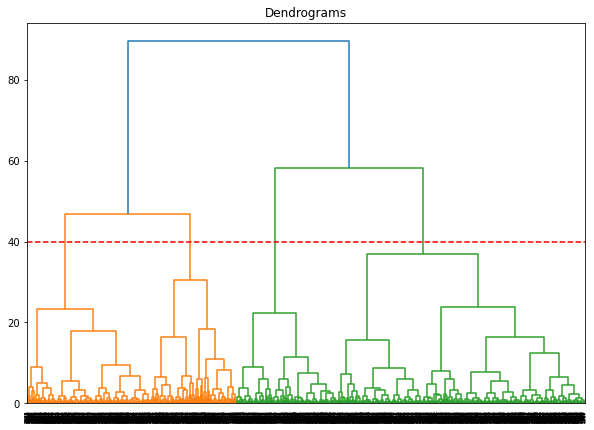

In [50]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms") 
dend = shc.dendrogram(shc.linkage(components, method='ward'))
plt.axhline(y=40, color='r', linestyle='--')

In [51]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(components)

array([2, 1, 3, ..., 1, 1, 3])

In [52]:
fig = px.scatter(components, x=0, y=1, color=cluster.labels_)
fig.show()